In [1]:
# 필요한 라이브러리 및 모듈 불러오기
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import sys
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append(r"C:\Users\dhshs\Documents\ganomaly_global")
sys.path.append(r"C:\Users\dhshs\Documents\ganomaly_global\lib")
from lib.model import Ganomaly  # lib/model.py에서 제공되는 GANomaly 모델 사용
from lib.evaluate import evaluate, roc  # evaluate.py에서 제공되는 평가 함수 사용
from lib.visualizer import Visualizer  # visualizer.py에서 제공되는 시각화 클래스 사용
from options import Options  # 옵션 파일

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
class CustomDataset(Dataset):
    def __init__(self, directory, label, transform=None):
        self.directory = directory
        self.transform = transform
        self.label = label  # 레이블 정보 추가
        self.images = [img for img in os.listdir(directory) if img.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.images[idx])
        image = Image.open(img_path).convert("L")  # 흑백 이미지로 변환

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(self.label, dtype=torch.long)  # 레이블 포함하여 반환


In [3]:
# 데이터셋 경로 설정
normal_train_dir = r"C:\Users\dhshs\Documents\ganomaly_global\dataset\ELPV\mono\train\0.normal"
abnormal_test_dir = r"C:\Users\dhshs\Documents\ganomaly_global\dataset\ELPV\mono\test\1.abnormal"
normal_test_dir = r"C:\Users\dhshs\Documents\ganomaly_global\dataset\ELPV\mono\test\0.normal"

# 데이터 전처리 및 데이터 로더 설정
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
])

# 학습 및 테스트 데이터셋 생성
train_dataset = CustomDataset(normal_train_dir, label=0, transform=transform)  # 학습 데이터셋 로드 (normal만)
normal_test_dataset = CustomDataset(normal_test_dir, label=0, transform=transform)  # 테스트 데이터셋 로드 (normal)
abnormal_test_dataset = CustomDataset(abnormal_test_dir, label=1, transform=transform)  # 테스트 데이터셋 로드 (abnormal)

# 두 개의 테스트 데이터셋을 합침
from torch.utils.data import ConcatDataset

test_dataset = ConcatDataset([normal_test_dataset, abnormal_test_dataset])

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


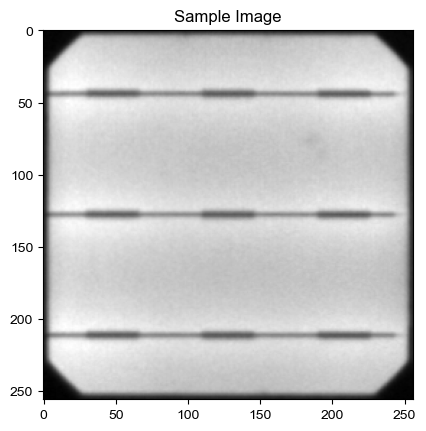

In [4]:
import matplotlib.pyplot as plt
import torch

# LaTeX 사용 비활성화
plt.rcParams["text.usetex"] = False

# 데이터 로더에서 샘플 하나 가져오기
sample_image = next(iter(train_loader))

# 첫 번째 이미지 선택 (배치 크기만큼 가져오므로 첫 번째만 선택)
sample_image = sample_image[0][0].squeeze(0)  # 배치 차원과 채널 차원을 제거

# 이미지 시각화
plt.rcParams["font.family"] = "Arial"
plt.imshow(sample_image, cmap='gray')
plt.title("Sample Image")
plt.show()


In [ ]:
# Jupyter Notebook의 매개변수를 무시하도록 설정
sys.argv = ['']

# 옵션 설정
opt = Options().parse()
opt.isize = 256  # 데이터의 이미지 크기
opt.nc = 1       # 흑백 이미지이므로 채널 수를 1로 설정
opt.batchsize = 32  # 배치 크기 설정
opt.save_test_images = True  # 테스트 이미지 저장 설정
opt.display = True  # 실시간 시각화 설정
opt.use_context_pred = True # 마스킹 설정

In [6]:
dataloader = {'train': train_loader, 'test': test_loader}  # 데이터 로더 설정

# GANomaly 모델 생성
model = Ganomaly(opt, dataloader)

Setting up a new session...


In [ ]:
model.train()

>> Training model Ganomaly.


  0%|          | 0/12 [00:00<?, ?it/s]c:\Users\dhshs\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\dhshs\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [ ]:
model.save_weights(49)

> #### 추가 학습

In [ ]:
# Jupyter Notebook의 매개변수를 무시하도록 설정
sys.argv = ['']

# 옵션 설정
opt = Options().parse()
opt.isize = 256  # 데이터의 이미지 크기
opt.nc = 1       # 흑백 이미지이므로 채널 수를 1로 설정
opt.batchsize = 32  # 배치 크기 설정
opt.save_test_images = True  # 테스트 이미지 저장 설정
opt.display = True  # 실시간 시각화 설정
opt.niter = 50
opt.resume = {
    'netg_path': r"C:\Users\dhshs\Documents\ganomaly_global\project\output(use masking_1)\ganomaly\ELPV\train\weights\epoch50_netG.pth",
    'netd_path': r"C:\Users\dhshs\Documents\ganomaly_global\project\output(use_masking_1)\ganomaly\ELPV\train\weights\epoch50_netD.pth"
}
opt.use_context_pred = True # 마스킹 설정

In [ ]:
dataloader = {'train': train_loader, 'test': test_loader}  # 데이터 로더 설정

# GANomaly 모델 생성
model = Ganomaly(opt, dataloader)

In [ ]:
model.train()

In [ ]:
model.save_weights(50)

In [ ]:
def evaluate_and_visualize(model, dataloader, device, threshold=None):
    """
    Evaluate the model and visualize the results, including test(normal) and test(anomaly) distributions.
    This function integrates the calculation of novelty scores.
    """
    model.netg.eval()  # Set the model to evaluation mode
    novelty_scores = []
    labels = []

    # Calculate novelty scores
    with torch.no_grad():
        for data in dataloader:
            inputs, targets = data[0].to(device), data[1].to(device)

            # Forward pass through NetG
            _, latent_i, latent_o = model.netg(inputs)

            # Calculate novelty score
            scores = torch.mean((latent_i - latent_o) ** 2, dim=1).cpu().numpy().flatten()
            novelty_scores.extend(scores)
            labels.extend(targets.cpu().numpy())

    # Convert to numpy arrays
    novelty_scores = np.array(novelty_scores)
    labels = np.array(labels)

    # Find threshold if not provided
    if threshold is None:
        fpr, tpr, thresholds = roc_curve(labels, novelty_scores)
        optimal_idx = np.argmax(tpr - fpr)
        threshold = thresholds[optimal_idx]

    # Generate predictions
    preds = (novelty_scores > threshold).astype(int)

    # Separate test scores into normal and anomaly based on true labels
    normal_scores = novelty_scores[labels == 0]
    anomaly_scores = novelty_scores[labels == 1]

    # Plot Novelty Scores Distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(normal_scores, color="green", label="Test (Normal)", kde=True, bins=30, stat="density", alpha=0.5)
    sns.histplot(anomaly_scores, color="red", label="Test (Anomalous)", kde=True, bins=30, stat="density", alpha=0.5)
    plt.axvline(x=threshold, color="black", linestyle="--", label="Threshold")
    plt.title("Novelty Scores Distribution")
    plt.xlabel("Novelty Score")
    plt.ylabel("Density")
    plt.xlim(0, 1)  # X-axis range limited to 0-1
    plt.legend()
    plt.show()

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, preds))

    return threshold


In [ ]:
# Evaluate and visualize
optimal_threshold = evaluate_and_visualize(model, test_loader, device)
print(f"Optimal Threshold: {optimal_threshold}")


In [ ]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_test_dataset(model, test_loader, threshold, device="cuda"):
    """
    설정된 임계값을 사용하여 test dataset에 대해 이상치를 판별하고 평가합니다.

    Args:
        model: GANomaly 모델 인스턴스
        test_loader: test sample을 포함한 DataLoader
        threshold (float): 이상치 판별을 위한 임계값
        device (str): 연산에 사용할 장치 (기본값: "cuda")
    """
    model.netg.eval()
    novelty_scores = []
    true_labels = []
    predictions = []

    with torch.no_grad():
        for data in test_loader:
            # 데이터 로드 및 device로 이동
            inputs, labels = data[0].to(device), data[1].to(device)
            if inputs.dim() == 3:
                inputs = inputs.unsqueeze(0)
            
            # latent 벡터 생성 및 novelty score 계산
            _, latent_i, latent_o = model.netg(inputs)
            scores = torch.mean((latent_i - latent_o) ** 2, dim=1)
            novelty_scores.extend(scores.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # 임계값을 사용해 이상 여부를 예측 (0: 정상, 1: 이상)
            pred = (scores >= threshold).int()
            predictions.extend(pred.cpu().numpy())

    # numpy 배열로 변환 및 차원 축소
    true_labels = np.array(true_labels).astype(int).flatten()
    predictions = np.array(predictions).astype(int).flatten()
    novelty_scores = np.array(novelty_scores).flatten()

    # Confusion matrix 생성 및 시각화
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks([0, 1], ["Normal", "Anomaly"])
    plt.yticks([0, 1], ["Normal", "Anomaly"])

    # 각 셀에 샘플 개수를 텍스트로 추가
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()

In [ ]:
# 사용 예시: test_loader를 입력으로 전달하고 threshold 적용
evaluate_test_dataset(model, test_loader, optimal_threshold, device=device)